### 統計學習與深度學習 (Fall, 2024)
### Homework 3

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。
如無其他規定，所有重要結果應顯示至小數點第四位(四捨五入)。


### 第一題 [Resnet as a Feature Extractor]

(30%) Resnet是一個常用的CNN影像分類的架構。許多深度學習平台，如Pytorch，提供已經在ImageNet資料集上訓練好的模型(i.e., 權重)。這些模型可以直接用來取代傳統的特徵工程。我們在本題與下一期要來嘗試與比較這個方向。

為了方便討論，我們使用Resnet50。當然同樣的作法可以用在其他類似的模型上。

Resnet50的模型架構大致上是

```
ResNet(
  (conv1):

   .... [omitted] ...

  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
)

```
我們忽略前面的所有層，只專注在最後一層。是一個線性層。輸入是2048維，輸出是1000維。因此如果要把訓練好的Resnet50當成是Feature Extractor，我們可以直些使用模型的最後輸出(尚未進入Softmax)的1000維向量，或是使用前一層的輸出，也就是2048維向量。本題將嘗試使用最後的1000維向量來代表一張圖片。下一題將使用前一層的輸出的2048維向量代表圖片。

請以Pytorch提供的預訓練模型(`torchvision.models.resnet50(weights="IMAGENET1K_V2")`)作為起點往下發展。

為了控制不同的分類器可能會帶來的影響。我們選用Logistic Regression作為最後圖片分類的分類器。也就是說每張在訓練集的圖片都通過同一個Pre-trained Resnet50，轉換成一個1000維的向量。然後訓練一個Logistic Regression做圖片分類。接下來把每一張測試資料通過同一個Pre-trained Resnet50轉換成1000維的向量。使用訓練好的Logistic Regression預測分類，並計算分類效能。

這裡的圖片分類任務我們選用Food101資料集。這個資料集有101類食物的照片。任務是看照片分類食物。

為了節省大家的資料整備時間，我們提供`food101_hwds.tgz`檔案。請下載並存放置工作目錄，並執行`tar zxvf food101_hwds.tgz ./`。你會在工作目錄看到一個food101目錄，下有一個food-101目錄，接下來是`images  license_agreement.txt  meta  README.txt`等檔案。

如果你的資料檔已經正確下載，就可以連上Data Loader:


我在以下的程式中，先隨機挑選了 20000 張照片。

In [ ]:
import torch
import torchvision
from torchvision import models, transforms, datasets
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler

imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]

valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_stats[0], imagenet_stats[1])])

batch_size = 196

trainset = torchvision.datasets.Food101(root='./food101', split="train",
                                        download=False, transform=valid_tfms)

sample_num = 20000
train_indices = np.random.choice(len(trainset), sample_num, replace=False)
train_sampler = SubsetRandomSampler(train_indices)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

validset = torchvision.datasets.Food101(root='./food101', split="test",
                                       download=False, transform=valid_tfms)

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=6)
validloader = DataLoader(validset, batch_size=batch_size, num_workers=6)

assert trainset.classes==validset.classes
classes = trainset.classes
classe2idx = trainset.class_to_idx
num_classes = len(classes)

print("Number of classes =", num_classes)

Number of classes = 101


這裡有101個分類。列出前幾個給大家參考:

In [ ]:
print(trainset.classes[0:10])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


為了給大家更具體的想法，下面是一些訓練集的照片與分類:

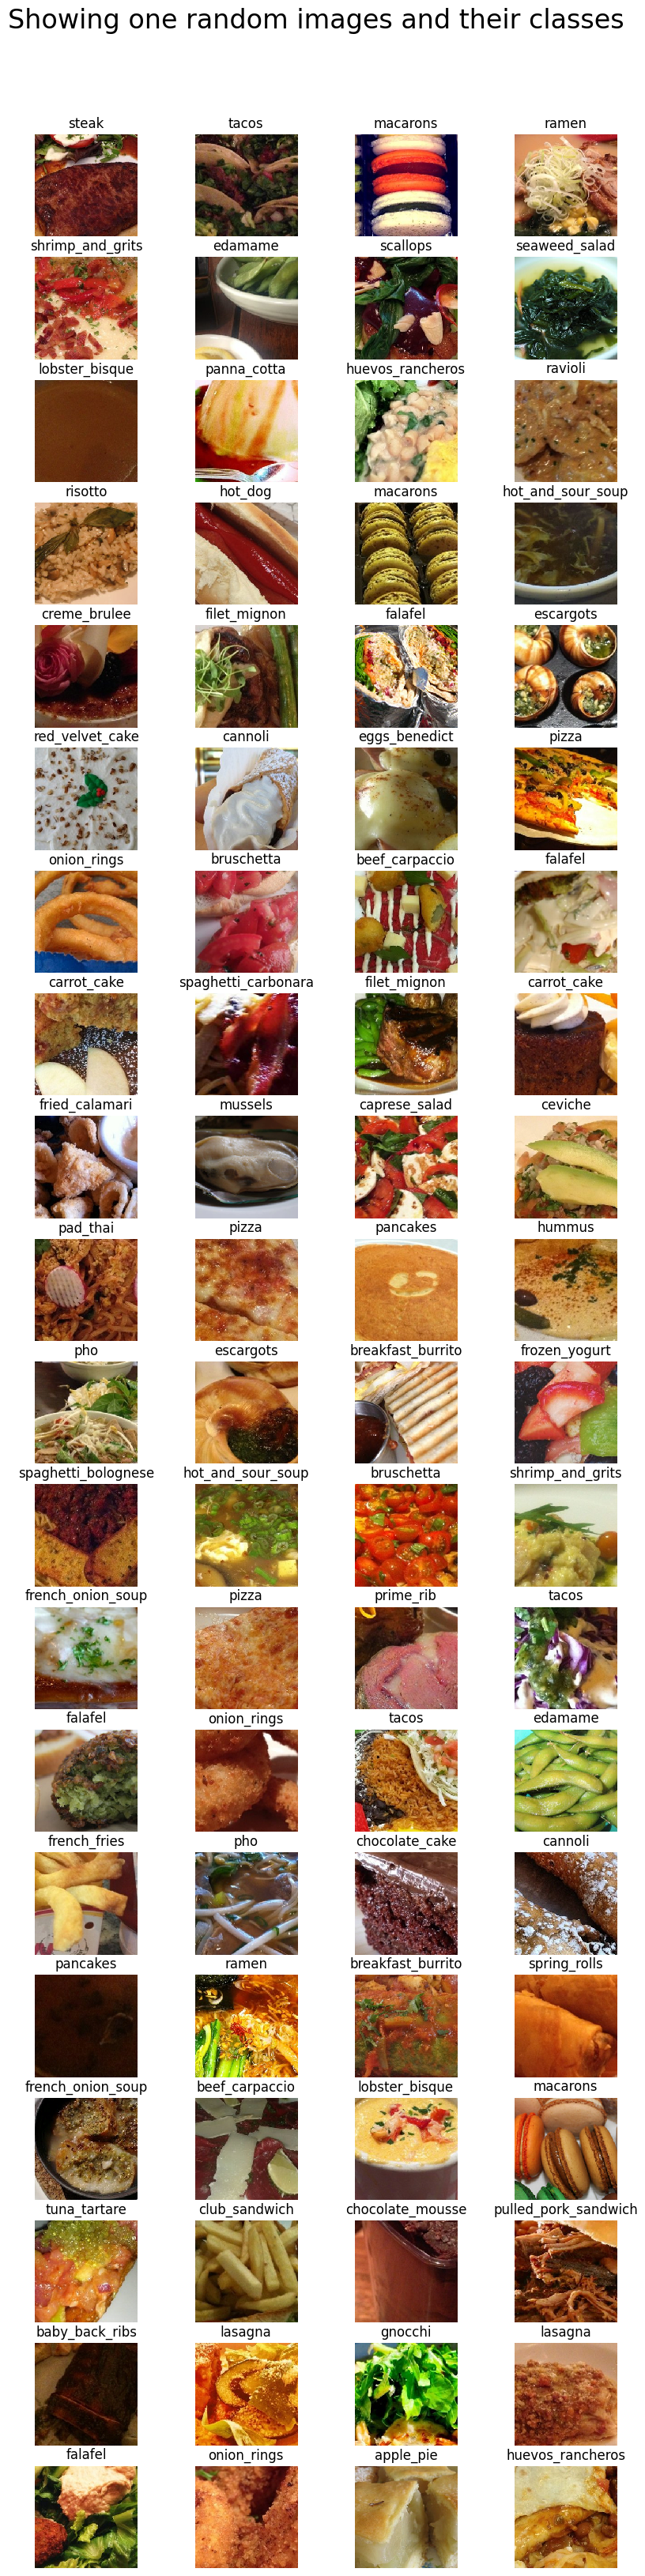

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,40))
fig.suptitle(f"Showing one random images and their classes", y=0.92, fontsize=24)
columns = 4
rows = 20
imgenet_mean = imagenet_stats[0]
imgenet_std = imagenet_stats[1]

targetset = trainset
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)

    img_xy = np.random.randint(len(targetset))
    np_img = targetset[img_xy][0].numpy()
    img = np.transpose(np_img, (1,2,0))
    img = img * imgenet_std + imgenet_mean

    plt.title(classes[targetset[img_xy][1]])
    plt.axis('off')
    img = np.clip(img, 0, 1)
    plt.imshow(img, interpolation='nearest')

plt.show()

注意:
1. 由於訓練集較大，請隨機在訓練集選取20000張照片訓練Logistic Regression。
2. 請不要調整測試集(Validation Set)
3. 本題主要的分類效能指標為Accuracy與Macro-average F1

以下的三個 cell 中，我先把 resnet50 的模型載下來，並且把它的權重設定為 ImageNet 的權重。
然後在 extract_fc_features 中，我把照片輸入 resnet50，並且把最後一層的 fc 層的輸出當作 feature。

In [ ]:
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights="IMAGENET1K_V2")

In [ ]:
def extract_fc_features(dataloader, model, device):
    features = []
    labels = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            features.append(outputs.squeeze().cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

以下進行 sanity check，確定 training set 和 validation set 的 features 有正確的 shape（x, 2048）。

In [ ]:
train_features, train_labels = extract_fc_features(trainloader, model, device)
print("Train features shape:", train_features.shape)  # 應該是 (N, 1000)

Train features shape: (20000, 1000)


In [ ]:
valid_features, valid_labels = extract_fc_features(validloader, model, device)
print("Valid features shape:", valid_features.shape)

Valid features shape: (25250, 1000)


最後我訓練一個 Logistic Regression 模型，使用 ResNet50 的最後 1000 維向量作為輸入，並且使用 scikit-learn 的 LogisticRegression 來訓練模型。

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)
valid_preds = clf.predict(valid_features)

print("Validation accuracy:", accuracy_score(valid_labels, valid_preds))
print("Validation F1 score:", f1_score(valid_labels, valid_preds, average="macro"))

Validation accuracy: 0.5238811881188119
Validation F1 score: 0.5237447221862704


從以上的訓練結果，我得到了以下數據：

在 validation set 上的預測 accuracy 是 0.5238811881188119，Macro-F1 是 0.5237447221862704。

----

### 第二題 [Resnet as a Feature Extractor, Part 2]

(20%) 呈上題，使用最後fc輸入的2048維作為特徵。訓練Logistic Regression，並計算分類績效。注意事項與前一題一樣。比較這兩種作法的結果。你覺得應該使用2048維或1000為作為特徵向量?

以下的幾個 cell 中，我一樣會使用 resnet50 來提取特徵，但這次提取的特徵是最後 fc 輸入的 2048 維特徵，而不是 1000 維特徵。 

In [ ]:
model = models.resnet50(weights="IMAGENET1K_V2")

In [ ]:
feature_extractor_2048 = torch.nn.Sequential(*list(model.children())[:-1])  # 保留avgpool層，去除fc層
feature_extractor_2048.eval()
feature_extractor_2048 = feature_extractor_2048.to(device)

In [ ]:
def extract_2048_features(dataloader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

以下同樣進行 sanity check，確定 training set 和 validation set 的 features 有正確的 shape（x, 2048）。

In [ ]:
train_features_2048, train_labels = extract_2048_features(trainloader, feature_extractor_2048, device)
train_features_2048 = train_features_2048.squeeze()
print("Train features shape:", train_features_2048.shape)  # 應該是 (N, 2048)

Train features shape: (20000, 2048)


In [ ]:
valid_features_2048, valid_labels = extract_2048_features(validloader, feature_extractor_2048, device)
valid_features_2048 = valid_features_2048.squeeze()
print("Valid features shape:", valid_features_2048.shape)

Valid features shape: (25250, 2048)


最後我訓練一個 Logistic Regression 模型，使用 ResNet50 的 fc layer features 作為輸入，並且使用 scikit-learn 的 LogisticRegression 來訓練模型。

In [ ]:
clf2 = LogisticRegression(max_iter=10000)
clf2.fit(train_features_2048, train_labels)
valid_preds_2048 = clf2.predict(valid_features_2048)

print("Validation accuracy:", accuracy_score(valid_labels, valid_preds_2048))
print("Validation F1 score:", f1_score(valid_labels, valid_preds_2048, average="macro"))

Validation accuracy: 0.5573861386138614
Validation F1 score: 0.5579683377248127


從以上的訓練結果，我得到了以下數據：

在 validation set 上的預測 accuracy 是 0.5573861386138614，Macro-F1 是 0.5579683377248127。

這兩項數據與上一題相比有所進步，但進步幅度不大，約為 0.03。

------



### 第三題 [Resnet Finetuning]

(50%) 接下來我們來嘗試一般的Fine-tuning作法。這個作法是以Pre-trained Resnet50做為起點，將最後一層(fc)換成適合這個分類任務的維度，也就是2048 --> 101的線性層，然後進行模型的Fine-tuning (i.e., training)。

這裡通常有兩種作法，一是在Back Propogation時調整所有的權重，二是只調整最後的fc層。請嘗試並比較這兩者的差別。

注意事項:
* 影像前處理在訓練階段與測試階段不同。訓練階段需要有RandomResizedCrop()與RandomHorizontalFlip()。測試階段則只需CenterCrop()。所有階段都需標準化。
* 訓練時請使用Early Stopping。Patient ＝ 5 epochs。最多訓練100 epochs
* 請使用全部訓練集與測試集。
* 本題主要的分類效能指標為Accuracy與Macro-average F1
* 請提供training loss, validation loss, validation accuracy, validation macro f1在訓練期間的線圖。
* 為了簡化問題。我們以訓練期間最佳的validation performance作為模型的一般性預測力指標。


In [ ]:
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

本題一樣使用 ResNet50 作為特徵提取器，不過這次我們將 ResNet50 的最後一層 fc 層改成一個 101 類的分類層。

In [ ]:
resnet50 = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 101)
resnet50 = resnet50.to(device)

#print the model
#print(resnet50)

以下根據題目指示針對 training set 和 testing set 進行 transform。

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
])

test_transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_stats[0], imagenet_stats[1])
])

以下讀入資料集。

In [ ]:
train_dataset = datasets.Food101(root='./food101', split="train", download=False, transform=train_transform)
test_dataset = datasets.Food101(root='./food101', split="test", download=False, transform=test_transform)

batch_size = 196
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

模型訓練的目標函數設定為 Cross Entropy Loss，優化器選用 Adam，學習率設定為 0.001，訓練最多 100 個 epoch。

Early stopping 機制設定為：如果連續 5 個 epoch 驗證集的 loss 都沒有下降，則停止訓練。

In [ ]:
criterion = nn.CrossEntropyLoss()
early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

evaluate_model() 函數的目的是評估模型在測試集上的表現，並計算模型的準確率和 F1 score。

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_samples = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    val_loss /= len(dataloader)
    accuracy = correct_predictions / total_samples
    val_f1 = f1_score(y_true, y_pred, average="macro")

    return val_loss, accuracy, val_f1

train_model() train_all_layers 參數控制是否訓練所有層，或只訓練最後一層。當 train_all_layers=True 時，所有層都會被訓練；當 train_all_layers=False 時，只有最後一層會被訓練。

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, train_all_layers=True, num_epochs = 100):
    if train_all_layers:
        for param in model.parameters():
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        y_true = []
        y_pred = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds==labels).sum().item()
            total_samples += inputs.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_predictions / total_samples
        train_f1 = f1_score(y_true, y_pred, average="macro")

        val_loss, val_acc, val_f1 = evaluate_model(model, val_loader, criterion)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        val_f1_history.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        #early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    return train_loss_history, val_loss_history, val_acc_history, val_f1_history


首先，訓練所有層的參數。

以下是訓練過程的結果：

In [ ]:
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

print("Training all layers")
train_loss_all, val_loss_all, val_acc_all, val_f1_all = train_model(resnet50, train_loader, test_loader, optimizer, criterion, train_all_layers=True, num_epochs=100)

Training all layers
Epoch 1/100, Train Loss: 2.0497, Train Acc: 0.4999, Train F1: 0.4975, Val Loss: 1.8926, Val Acc: 0.5273, Val F1: 0.5282
Epoch 2/100, Train Loss: 1.4106, Train Acc: 0.6395, Train F1: 0.6378, Val Loss: 1.4023, Val Acc: 0.6347, Val F1: 0.6380
Epoch 3/100, Train Loss: 1.2357, Train Acc: 0.6815, Train F1: 0.6805, Val Loss: 1.7019, Val Acc: 0.5776, Val F1: 0.5819
Epoch 4/100, Train Loss: 1.1114, Train Acc: 0.7086, Train F1: 0.7078, Val Loss: 1.3140, Val Acc: 0.6568, Val F1: 0.6586
Epoch 5/100, Train Loss: 1.0370, Train Acc: 0.7283, Train F1: 0.7276, Val Loss: 1.3908, Val Acc: 0.6352, Val F1: 0.6390
Epoch 6/100, Train Loss: 0.9623, Train Acc: 0.7451, Train F1: 0.7448, Val Loss: 1.2069, Val Acc: 0.6831, Val F1: 0.6832
Epoch 7/100, Train Loss: 0.9143, Train Acc: 0.7553, Train F1: 0.7547, Val Loss: 1.1884, Val Acc: 0.6865, Val F1: 0.6919
Epoch 8/100, Train Loss: 0.8681, Train Acc: 0.7689, Train F1: 0.7684, Val Loss: 1.1584, Val Acc: 0.6941, Val F1: 0.6980
Epoch 9/100, Train L

在訓練所有層的情況下，最後達到的最佳 validation accuracy 為 0.7315，最佳 Macro-F1 score 為 0.7313，訓練了 19 個 epoch 之後就 early stop。

以下重新初始化模型，並且只訓練最後一層的全連接層。

以下是訓練過程的結果：

In [ ]:
resnet50 = models.resnet50(weights="IMAGENET1K_V2")
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 101)
resnet50 = resnet50.to(device)
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

print("Training only the fc layer")
train_loss_fc, val_loss_fc, val_acc_fc, val_f1_fc = train_model(resnet50, train_loader, test_loader, optimizer, criterion, train_all_layers=False, num_epochs=100)

Training only the fc layer
Epoch 1/100, Train Loss: 3.0612, Train Acc: 0.3634, Train F1: 0.3497, Val Loss: 2.4415, Val Acc: 0.4505, Val F1: 0.4364
Epoch 2/100, Train Loss: 2.2193, Train Acc: 0.4938, Train F1: 0.4838, Val Loss: 2.1355, Val Acc: 0.4977, Val F1: 0.4869
Epoch 3/100, Train Loss: 1.9972, Train Acc: 0.5288, Train F1: 0.5212, Val Loss: 1.9979, Val Acc: 0.5210, Val F1: 0.5105
Epoch 4/100, Train Loss: 1.8718, Train Acc: 0.5525, Train F1: 0.5460, Val Loss: 1.9390, Val Acc: 0.5279, Val F1: 0.5186
Epoch 5/100, Train Loss: 1.8014, Train Acc: 0.5648, Train F1: 0.5590, Val Loss: 1.8717, Val Acc: 0.5436, Val F1: 0.5375
Epoch 6/100, Train Loss: 1.7409, Train Acc: 0.5766, Train F1: 0.5715, Val Loss: 1.8572, Val Acc: 0.5423, Val F1: 0.5364
Epoch 7/100, Train Loss: 1.6887, Train Acc: 0.5868, Train F1: 0.5818, Val Loss: 1.8124, Val Acc: 0.5526, Val F1: 0.5467
Epoch 8/100, Train Loss: 1.6595, Train Acc: 0.5929, Train F1: 0.5882, Val Loss: 1.7976, Val Acc: 0.5552, Val F1: 0.5493
Epoch 9/100, 

在只訓練最後一層 fc layer 的情況下，最後達到的最佳 validation accuracy 為 0.5661，最佳 Macro-F1 score 為 0.5594，訓練了 20 個 epoch 之後就 early stop。

和訓練所有層的結果比起來，只訓練最後一層的結果明顯比較差。validation accuracy 和 Macro-F1 score 大概都低了 0.15~0.20。我認為是因為 training all layers 可以讓模型有更大的彈性。

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(train_loss, val_loss, val_acc, val_f1, label):
    epochs = range(1, len(train_loss)+1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = f"{label} Train Loss")
    plt.plot(epochs, val_loss, label = f"{label} Validation Loss")
    plt.title("Loss over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_acc, label = f"{label} Validation Accuracy")
    plt.plot(epochs, val_f1, label = f"{label} Validation F1")
    plt.title("Accuracy and F1 over epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy/F1")
    plt.legend()

    plt.show()

以下對於兩種訓練方式的結果進行作圖（training loss, validation loss, validation accuracy, validation macro f1），首先為訓練所有層的結果：

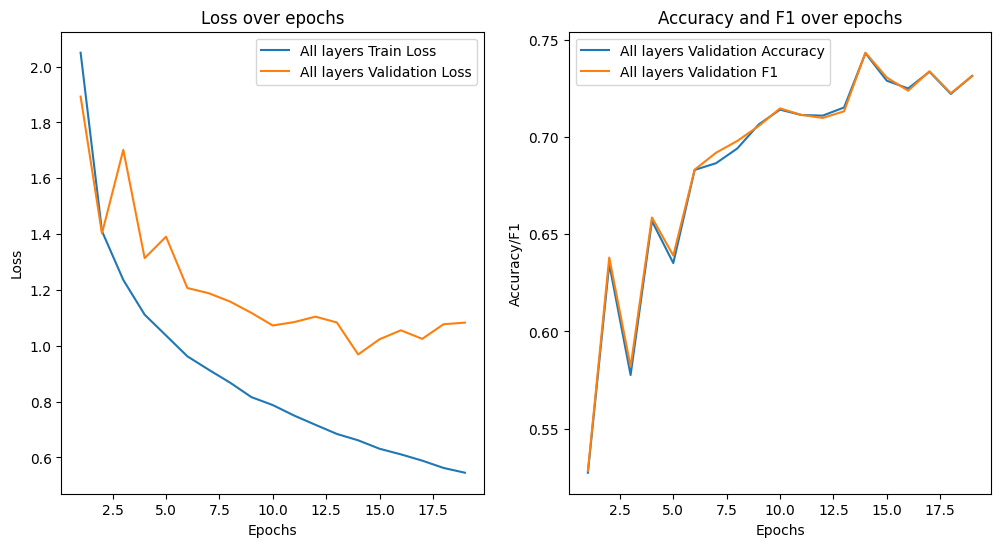

In [ ]:
plot_metrics(train_loss_all, val_loss_all, val_acc_all, val_f1_all, "All layers")

接著為只訓練最後一層的結果。

可以看到除了 training loss 之外，其他線圖的浮動都比較訓練所有層的線圖小：

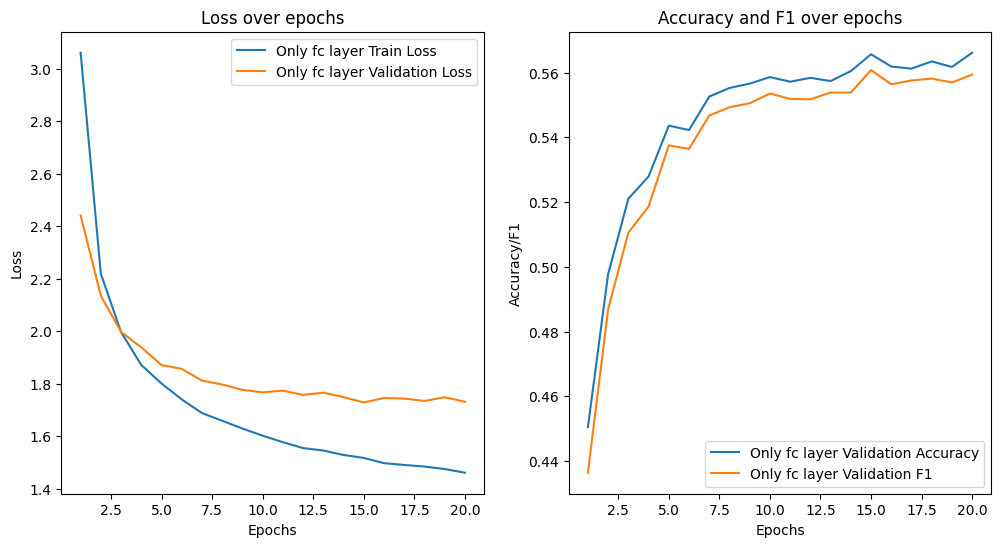

In [ ]:
plot_metrics(train_loss_fc, val_loss_fc, val_acc_fc, val_f1_fc, "Only fc layer")

------
